2912.0 0.0
Processing original model from file: /Users/ashokrd/Downloads/all_jsonl_files/plot_data_WSD_94_original.jsonl
Number of predicted values: 17664


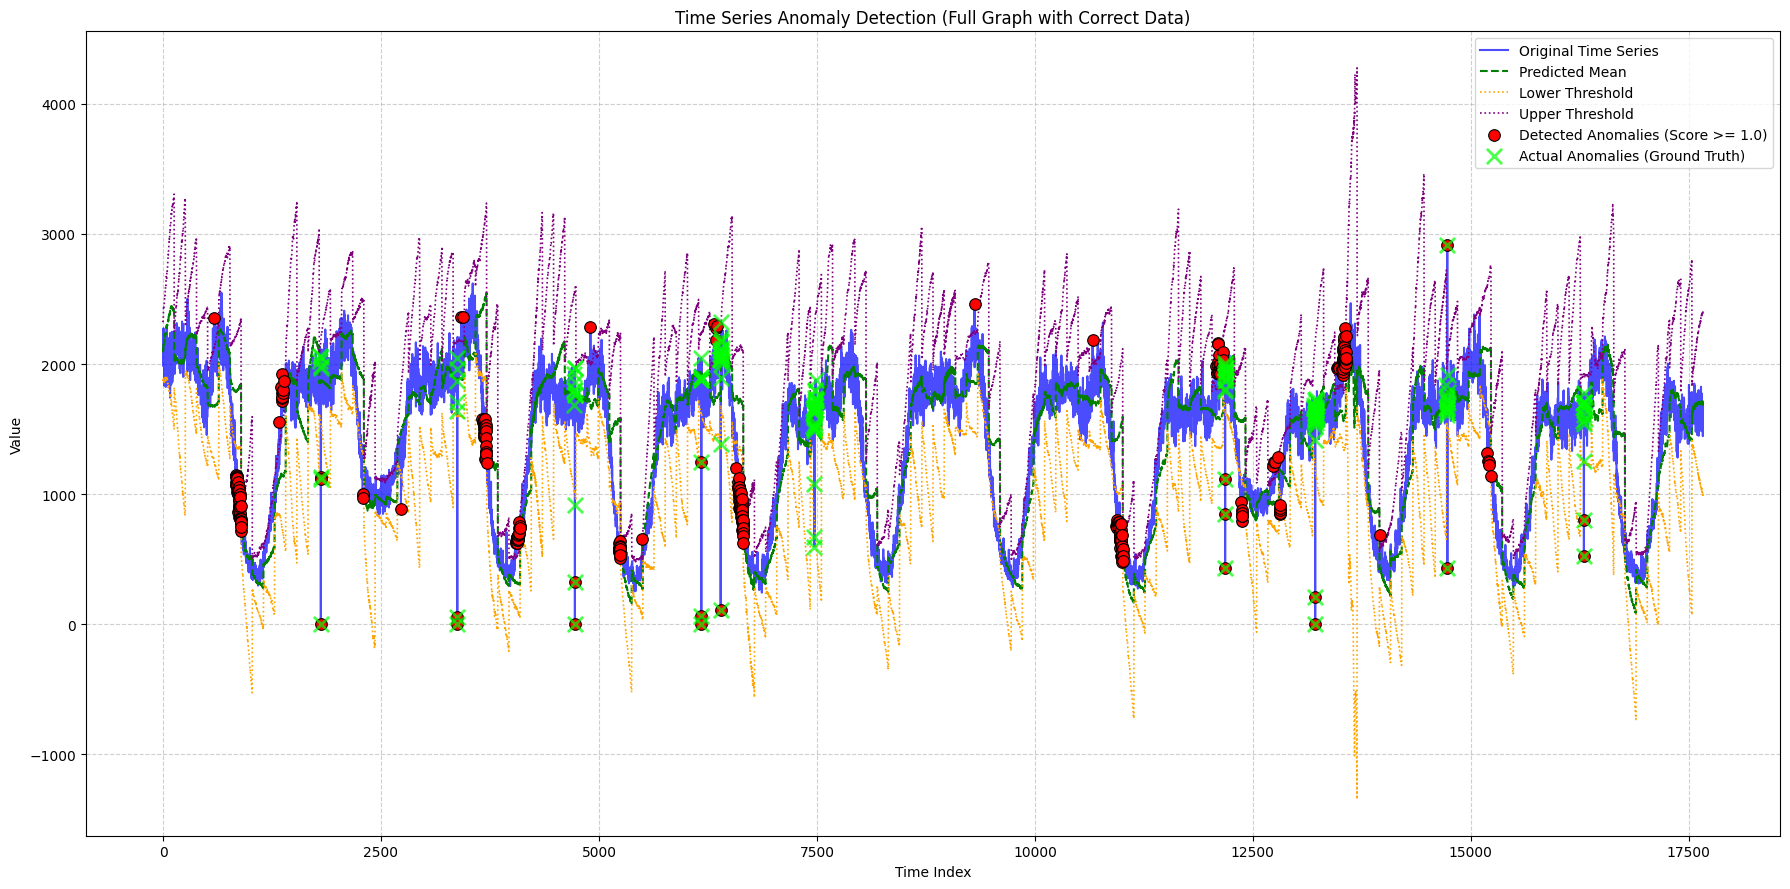

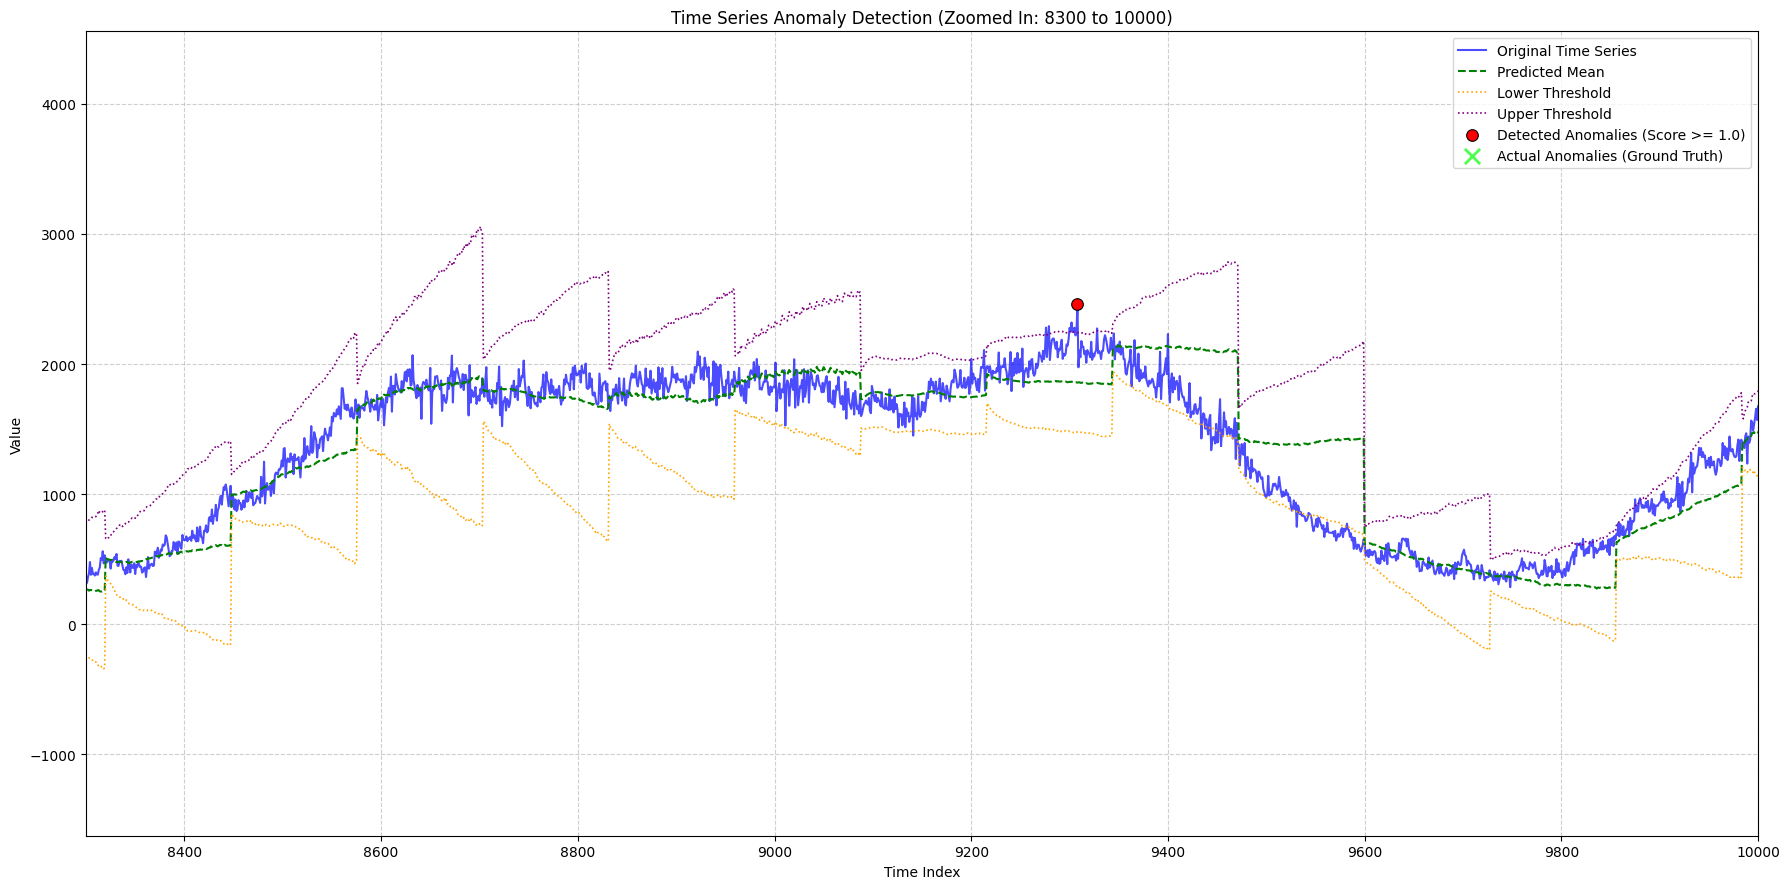

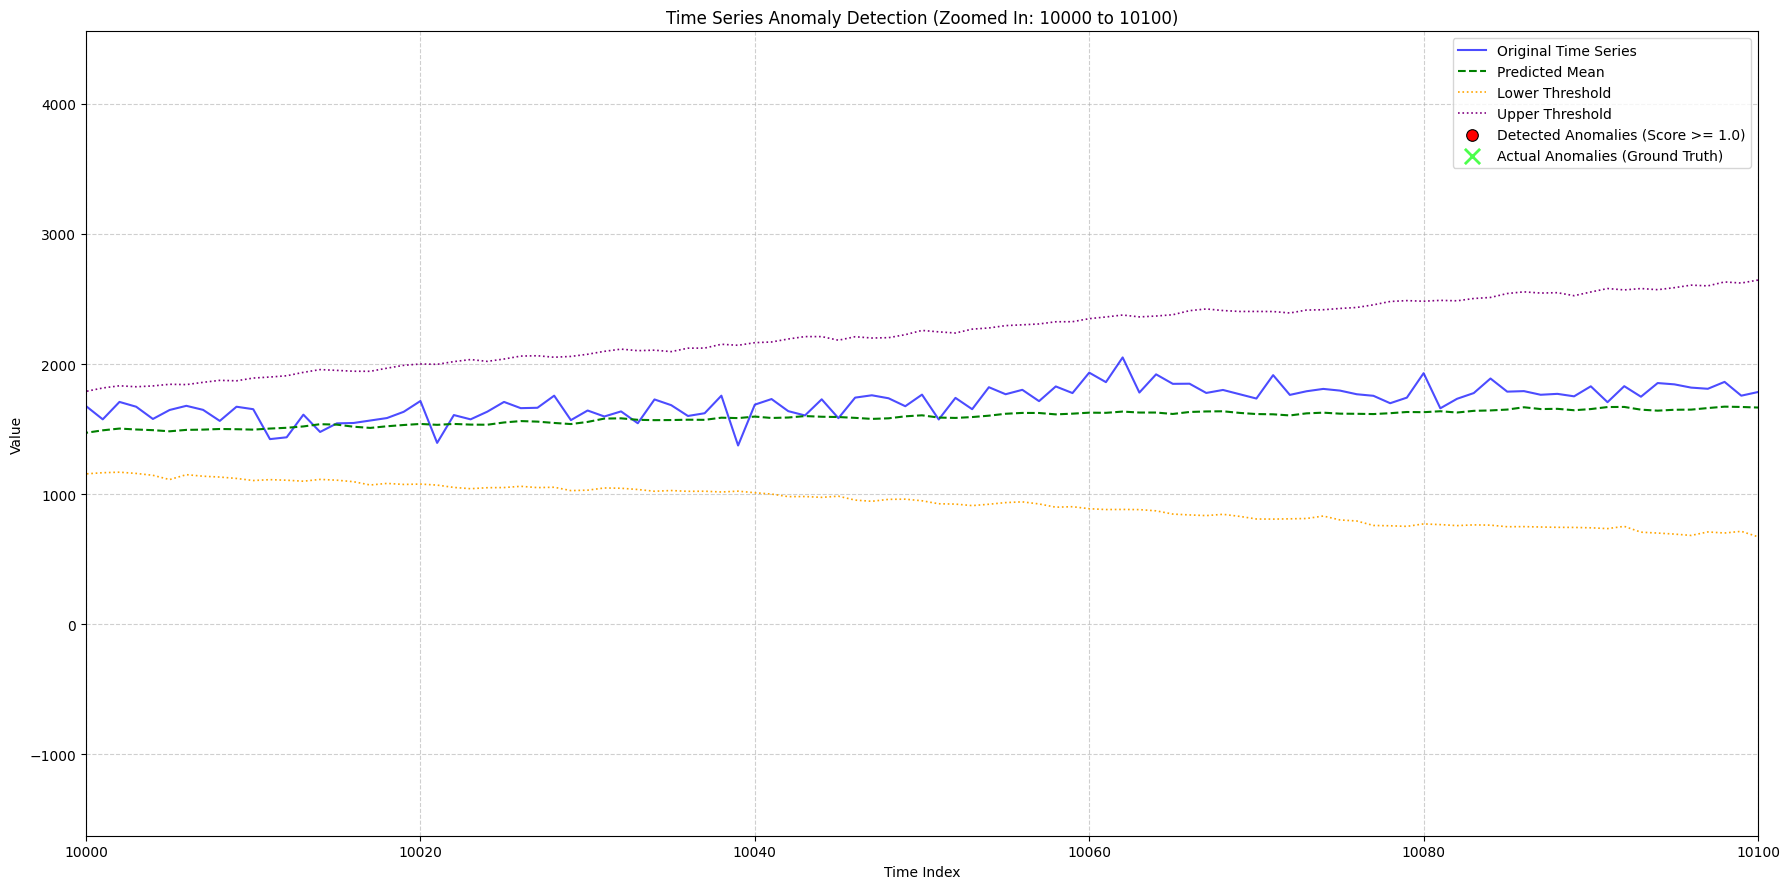

Plots have been generated and saved with the corrected original data.
Processing finetuned model from file: /Users/ashokrd/Developer/timesfm_experiment_graphs/WSD_94_hyperparameter/plot_data_epoch_8_finetuned.jsonl
Number of predicted values: 17664


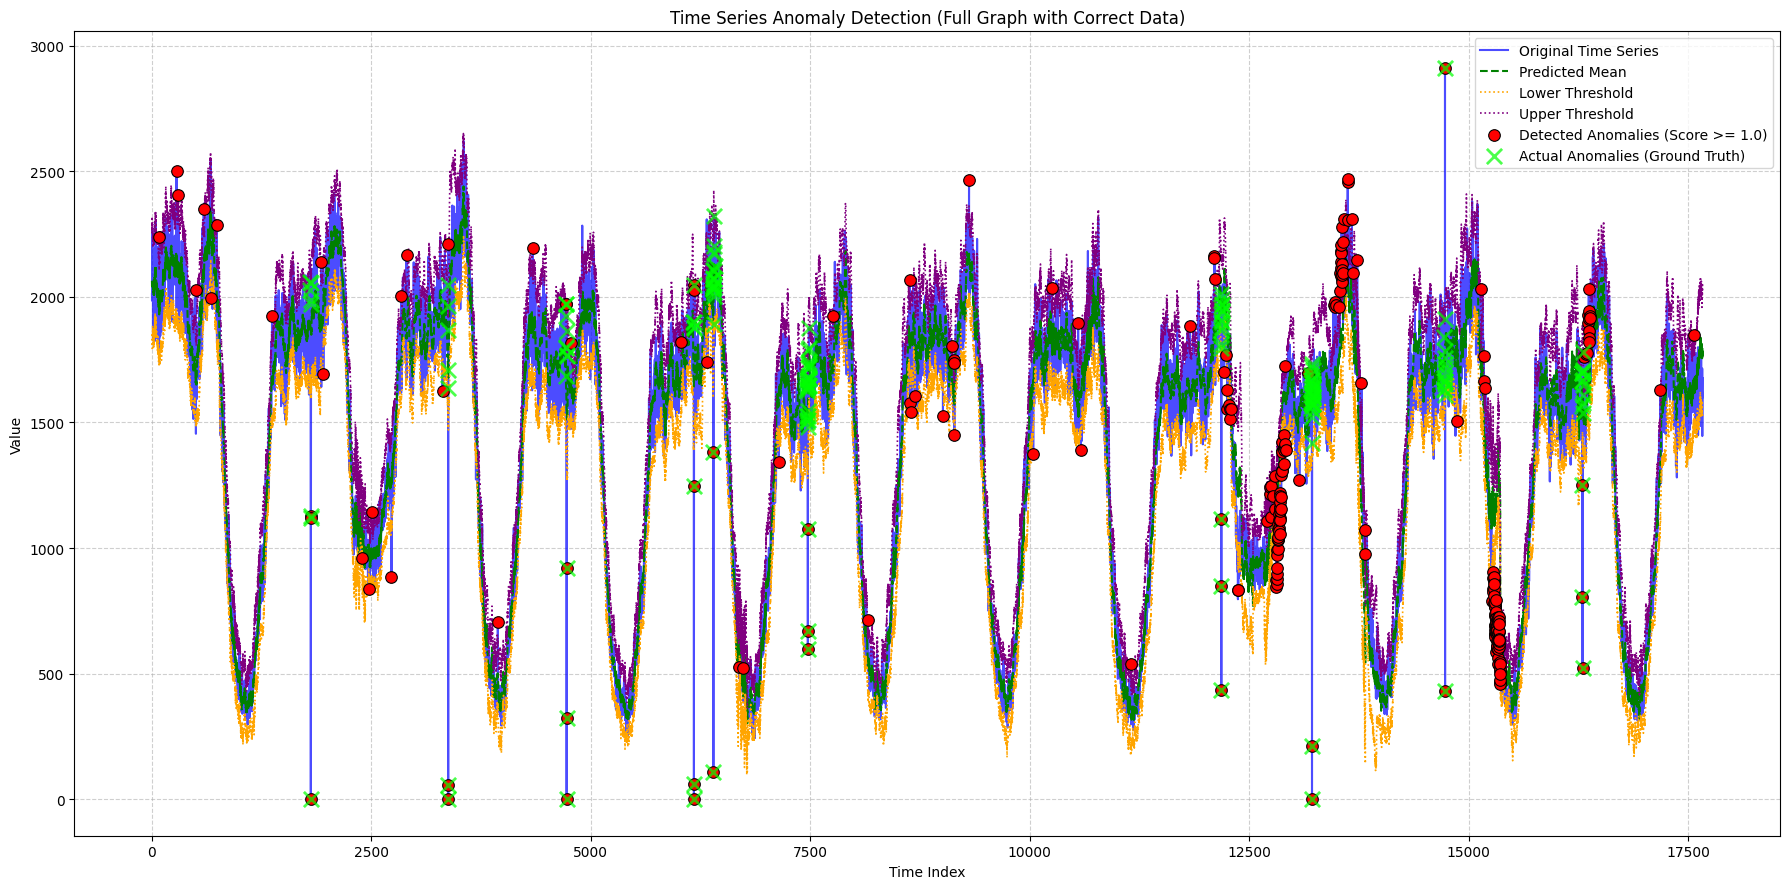

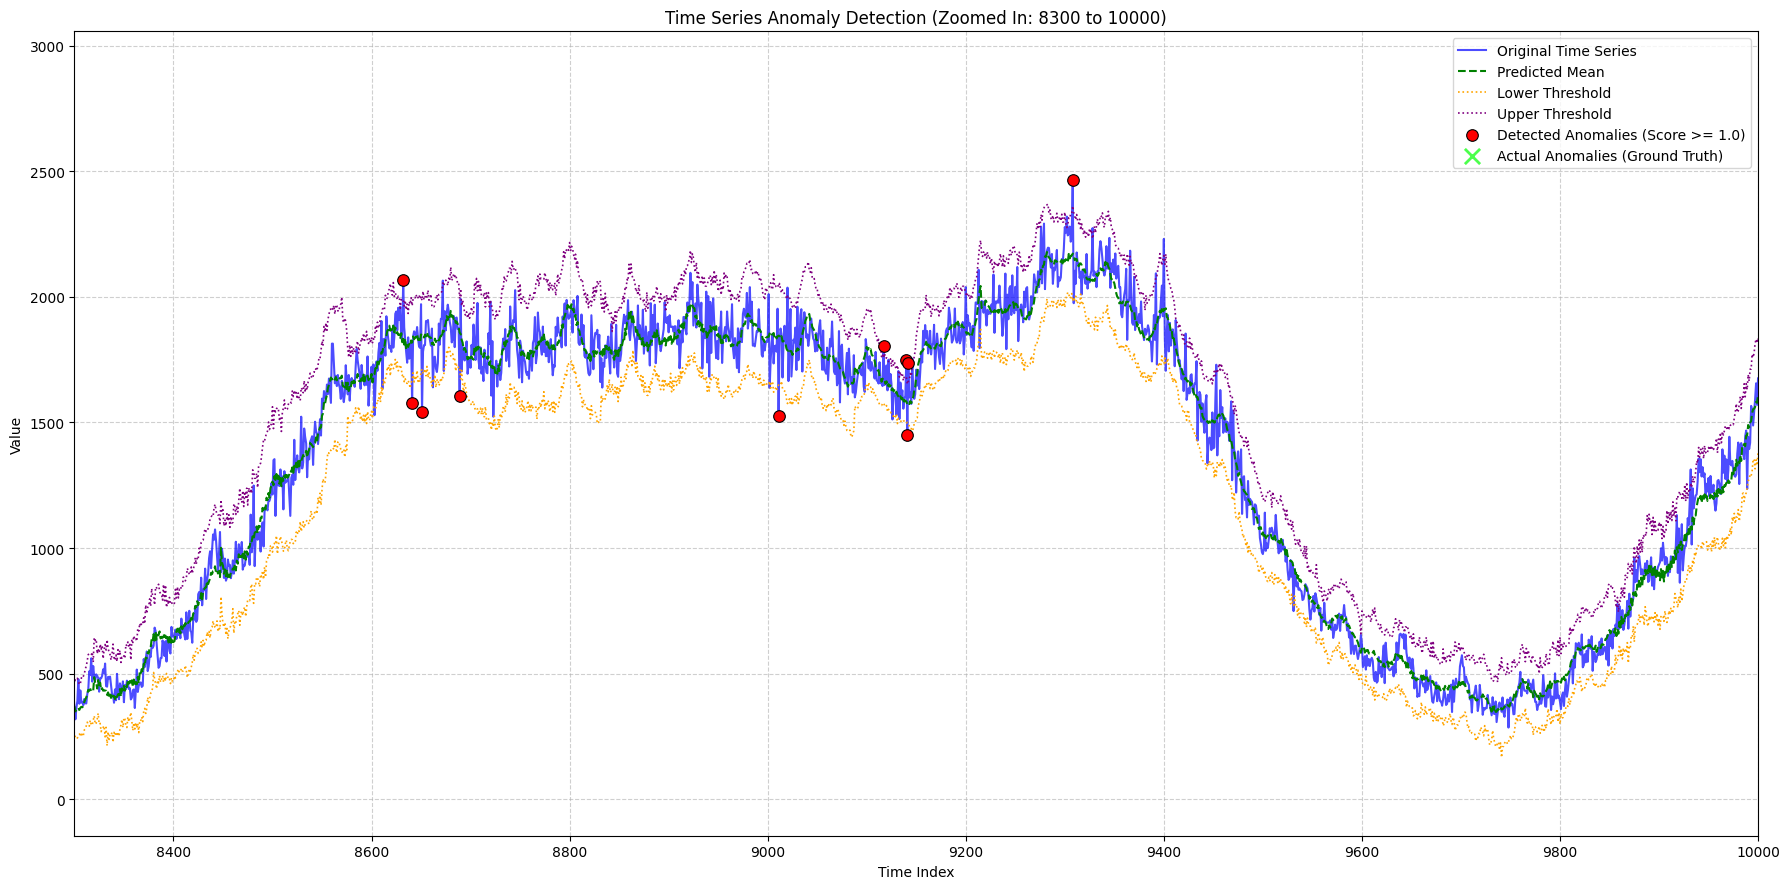

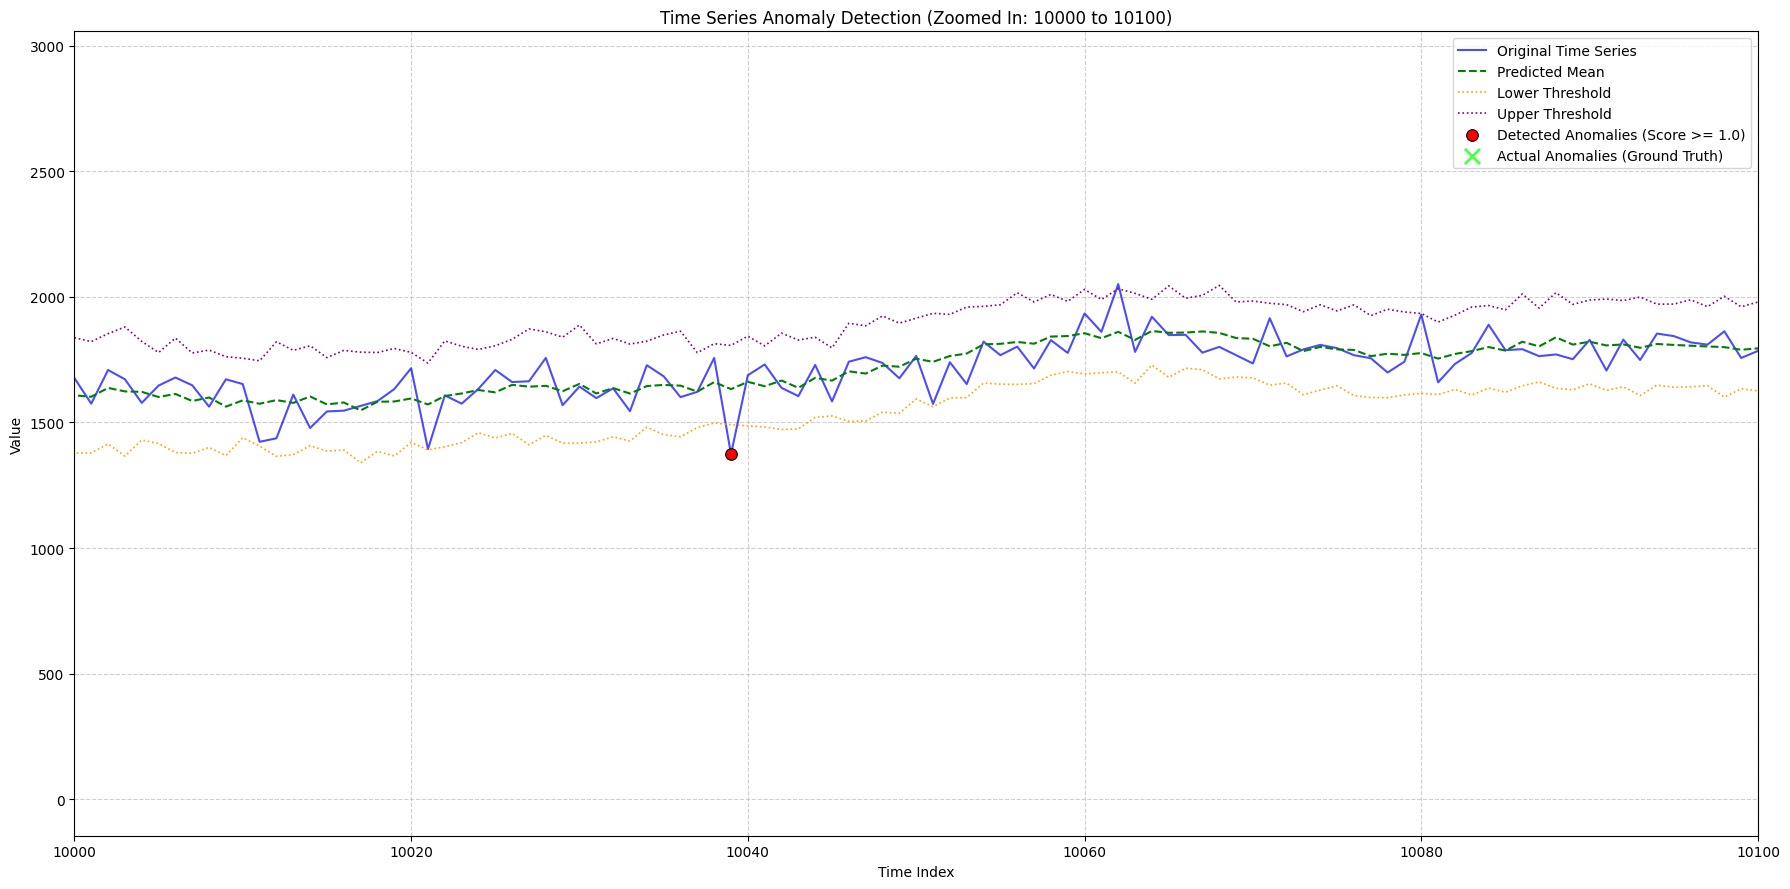

Plots have been generated and saved with the corrected original data.


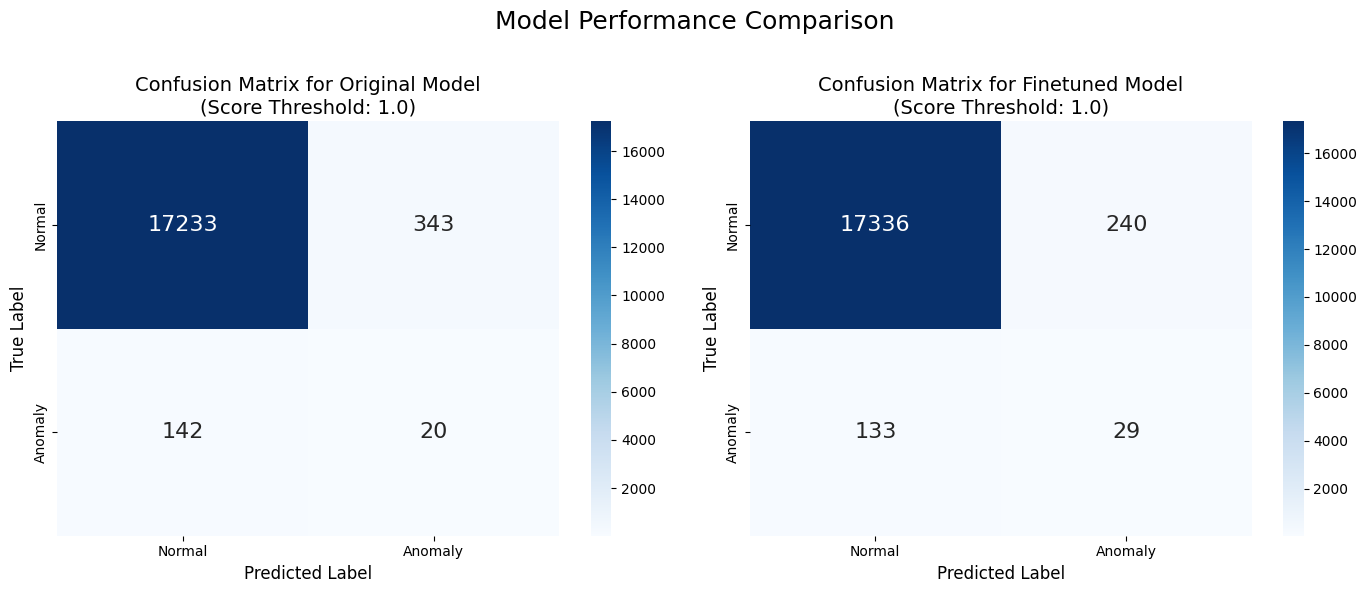

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
CONTEXT_LEN = 512


def plot_anomalies_and_forecast(
    values_array,
    all_anomalies,
    all_predicted_values,
    all_q20_values,
    all_q30_values,
    all_q70_values,
    all_q80_values,
    true_anomaly_indices, # NEW: Added parameter for true anomaly indices
    true_anomaly_values,
    title_suffix="",
    x_lims=None,
    min_outlier_score_for_plot=0,
    context_len=512,
    output_filename="plot.png"
):
    # The key from your file is 'outlier_score'
    filtered_anomalies = [a for a in all_anomalies if a['outlier_score'] >= min_outlier_score_for_plot]
    # The key from your file is 'timestamp'
    anomaly_indices = [(a['timestamp']) for a in filtered_anomalies]
    anomaly_values = [a['actual_value'] for a in filtered_anomalies]

    Q1 = np.nanmean([all_q20_values, all_q30_values], axis=0)
    Q3 = np.nanmean([all_q70_values, all_q80_values], axis=0)
    IQR = Q3 - Q1
    upper_thresh = Q3 + 1.5 * IQR
    lower_thresh = Q1 - 1.5 * IQR

    plt.figure(figsize=(18, 9))
    # This now plots the correct original data for the horizon
    plt.plot(values_array[context_len:], label='Original Time Series', color='blue', alpha=0.7, linewidth=1.5)

    plt.plot(all_predicted_values, label='Predicted Mean', color='green', linestyle='--', linewidth=1.5)
    plt.plot(lower_thresh, label='Lower Threshold', color='orange', linestyle=':', linewidth=1.2)
    plt.plot(upper_thresh, label='Upper Threshold', color='purple', linestyle=':', linewidth=1.2)

    plt.scatter([i - context_len for i in anomaly_indices], anomaly_values,
                color='red', s=70, zorder=5,
                label=f'Detected Anomalies (Score >= {min_outlier_score_for_plot:.1f})',
                marker='o', edgecolors='black', linewidths=0.8)

        # NEW: Plot the actual anomalies using the shifted indices
    plt.scatter(true_anomaly_indices, true_anomaly_values,
                color='lime', s=120, zorder=6,
                label='Actual Anomalies (Ground Truth)',
                marker='x', linewidths=2, alpha=0.7)

    plt.title(f'Time Series Anomaly Detection {title_suffix}')
    plt.xlabel('Time Index')
    plt.ylabel('Value')
    if x_lims:
        plt.xlim(x_lims[0], x_lims[1])
    
    # plt.ylim(-2, 3)

    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    # plt.savefig(output_filename) # Save the plot to a file
    plt.show()
    plt.close() # Close the figure to free memory

# --- Main Script Logic ---
plots = ["/Users/ashokrd/Downloads/all_jsonl_files/plot_data_WSD_94_original.jsonl", 
         "/Users/ashokrd/Developer/timesfm_experiment_graphs/WSD_94_hyperparameter/plot_data_epoch_2_finetuned.jsonl"]
file_path = "/Users/ashokrd/Downloads/TSB-UAD-Public-v2/WSD/WSD_94.csv"
df = pd.read_csv(file_path)
data_values = df['Data'].to_numpy()
print(max(data_values), min(data_values))
labels = df['Label'].to_numpy()

confusion_matrices = {}
MIN_OUTLIER_SCORE = 1.0  # Define the threshold


for plot in plots:
    model_type = "original" if "original" in plot else "finetuned"
    print(f"Processing {model_type} model from file: {plot}")
# 1. Read and parse the data from the Beam output file
    all_window_data = []
    # Make sure 'plot_data.jsonl' is in the same directory as this script
    try:
        with open(plot, 'r') as f:
            for line in f:
                # Check for empty lines that might have been added
                if line.strip():
                    all_window_data.append(json.loads(line))
    except FileNotFoundError:
        print("Error: 'plot_data.jsonl' not found. Please make sure the file is in the correct directory.")
        exit()


    # 2. Sort data by timestamp to ensure the correct order
    all_window_data.sort(key=lambda x: x['start_ts_micros'])

    # 3. Reconstruct the full data arrays
    all_anomalies = []
    all_predicted_values = []
    all_q20_values = []
    all_q30_values = []
    all_q70_values = []
    all_q80_values = []
    all_actual_horizon_values = [] # This will hold the real "blue line" data

    for window_data in all_window_data:
        all_predicted_values.extend(window_data['predicted_values'])
        all_q20_values.extend(window_data['q20_values'])
        all_q30_values.extend(window_data['q30_values'])
        all_q70_values.extend(window_data['q70_values'])
        all_q80_values.extend(window_data['q80_values'])
        # Populate the list with the actual values from the file
        all_actual_horizon_values.extend(window_data.get('actual_horizon_values', []))
        all_anomalies.extend(window_data.get('anomalies', []))

    # --- Confusion Matrix Calculation ---
    true_labels_horizon = labels[CONTEXT_LEN:]
    predicted_labels_horizon = np.zeros_like(true_labels_horizon)

    # Filter anomalies by score and update predicted_labels
    filtered_anomalies = [a for a in all_anomalies if a['outlier_score'] >= MIN_OUTLIER_SCORE]
    for anomaly in filtered_anomalies:
        # The anomaly timestamp is the absolute index in the original data
        anomaly_idx = anomaly['timestamp']
        # We need to map it to the horizon part of the data
        if anomaly_idx >= CONTEXT_LEN:
            horizon_idx = int(anomaly_idx) - CONTEXT_LEN
            if horizon_idx < len(predicted_labels_horizon):
                predicted_labels_horizon[horizon_idx] = 1
        # Compute and store the confusion matrix
    cm = confusion_matrix(true_labels_horizon, predicted_labels_horizon)
    confusion_matrices[model_type] = cm


    # 4. Convert lists to NumPy arrays
    all_predicted_values = np.array(all_predicted_values)
    print(f"Number of predicted values: {len(all_predicted_values)}")
    all_q20_values = np.array(all_q20_values)
    all_q30_values = np.array(all_q30_values)
    all_q70_values = np.array(all_q70_values)
    all_q80_values = np.array(all_q80_values)

    # 4. NEW: Find and prepare the actual anomaly data for plotting
    true_anomaly_indices_full = np.where(labels == 1)[0]
    # We only care about anomalies that occur AFTER the context window
    true_anomaly_indices_horizon = true_anomaly_indices_full
    # Get the corresponding values for these anomalies
    true_anomaly_values = data_values[true_anomaly_indices_horizon]
    # Shift the indices to align with the plot's x-axis, which starts at 0
    true_anomaly_plot_indices = true_anomaly_indices_horizon - CONTEXT_LEN


    # 6. Construct the `values_array` using the REAL data from your file
    # Create a dummy context so the array has the right shape for the plotting function.
    # The first real value is used to make the context visually seamless.
    if all_actual_horizon_values:
        dummy_context = [all_actual_horizon_values[0]] * CONTEXT_LEN
        values_array = np.array(dummy_context + all_actual_horizon_values)
    else:
        # Fallback in case the file is empty or missing the actual_horizon_values key
        print("Warning: 'actual_horizon_values' not found. The original time series plot will be empty.")
        total_len = CONTEXT_LEN + len(all_predicted_values)
        values_array = np.zeros(total_len)

    # 7. Call the plotting functions
    if values_array.any():
        # Plotting function for full graph
        plot_anomalies_and_forecast(
            values_array, all_anomalies, all_predicted_values,
            all_q20_values, all_q30_values, all_q70_values, all_q80_values,
            true_anomaly_plot_indices, true_anomaly_values, # NEW: Pass actual anomalies
            title_suffix="(Full Graph with Correct Data)",
            min_outlier_score_for_plot=1, # Set a score threshold
            context_len=512,
            output_filename="full_graph_correct.png"
        )

        # Plotting function for zoomed-in graphs
        zoom_ranges = [(8300, 10000), (10000, 10100)]
        for i, (start_idx, end_idx) in enumerate(zoom_ranges):
            # Adjust x_lims for the fact that the plotted array is sliced by context_len
            plot_x_start = max(0, start_idx)
            plot_x_end = end_idx

            plot_anomalies_and_forecast(
                values_array, all_anomalies, all_predicted_values,
                all_q20_values, all_q30_values, all_q70_values, all_q80_values,
                true_anomaly_plot_indices, true_anomaly_values, # NEW: Pass actual anomalies
                title_suffix=f"(Zoomed In: {start_idx} to {end_idx})",
                x_lims=(plot_x_start, plot_x_end),
                min_outlier_score_for_plot=1,
                context_len=512,
                output_filename=f"zoomed_graph_correct_{i}.png"
            )
        print("Plots have been generated and saved with the corrected original data.")
    else:
        print("No data found to plot.")

# --- Plotting Side-by-Side Confusion Matrices ---
if len(confusion_matrices) == 2:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for ax, (model_type, cm) in zip(axes, confusion_matrices.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Normal', 'Anomaly'],
                    yticklabels=['Normal', 'Anomaly'],
                    annot_kws={"size": 16})
        ax.set_title(f'Confusion Matrix for {model_type.capitalize()} Model\n(Score Threshold: {MIN_OUTLIER_SCORE})', fontsize=14)
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)

    plt.suptitle('Model Performance Comparison', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Could not generate comparison plot. Ensure both 'original' and 'finetuned' files were processed.")
